In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd[0]) * 24
    
    return hours_since_start


In [3]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.95 # start with full 
print(config)

{'initial': 228.9405, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


In [4]:
ryan_pvt = pd.read_csv('ColdNight1_PowerVsTime.csv',delimiter=',', header= None)

ryan_pvt = ryan_pvt.drop(11, axis =0)
ryan_pvt = ryan_pvt.drop(12, axis =0)
ryan_pvt = ryan_pvt.drop(14, axis =0)
ryan_pvt = ryan_pvt.drop(15, axis =0) ## removes extra rows at the bottom


ryan_pvt= ryan_pvt.T ## flips
ryan_pvt.columns = ryan_pvt.iloc[0] ## sets col
ryan_pvt = ryan_pvt.drop(0)

ryan_pvt['Summed_all'] = ryan_pvt['PMU Q_SUM'].astype(float)+ryan_pvt['PFPS_Q_SUM'].astype(float)+ryan_pvt['PDU_Q_SUM'].astype(float)+ryan_pvt['DCB_Q_SUM'].astype(float)+ryan_pvt['Spectrometer_Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 1 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 2 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 3 Q_SUM'].astype(float) +ryan_pvt['Pre-Amp 4 Q_SUM'].astype(float)+ryan_pvt['Radio_SUM'].astype(float)+ryan_pvt['POHTR_BATT'].astype(float)

ryan_pvt = ryan_pvt[0:2362] ## removes min max)
ryan_pvt['Nodes/Times'].astype(float)
#print(ryan_pvt)

1         0.000000
2         0.277778
3         0.555556
4         0.833333
5         1.111111
           ...    
2358    654.722222
2359    655.000000
2360    655.277778
2361    655.555556
2362    655.716667
Name: Nodes/Times, Length: 2362, dtype: float64

In [5]:
sol_pvt = pd.read_csv('solpow_v_time.csv',delimiter=',')
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['time'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(ryan_pvt['Nodes/Times'])]

# interp1d lunar power data to the time points of batt_hrs
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['solar_pow'], fill_value='extrapolate')
lunar_pow_interp = interp_func(pd.to_numeric(ryan_pvt['Nodes/Times']))
print(len(lunar_pow_interp))


2362


In [6]:
################   NIGHT CYCLE  ##################################
ryan_pvt = ryan_pvt[ryan_pvt['Nodes/Times'] > 180]

            Time       SOC  Power_hardware  Power_sol_pan
650   180.277778  0.955219           22.74       0.000000
651   180.555556  0.954415           22.74       0.000000
652   180.833333  0.953611           22.74       0.000000
653   181.111111  0.952807           22.74       0.000000
654   181.388889  0.952003           22.74       0.000000
...          ...       ...             ...            ...
2358  654.722222  1.000000           25.30     123.499062
2359       655.0  1.000000           25.30     123.451783
2360  655.277778  1.000000           25.30     123.403833
2361  655.555556  1.000000           25.30     123.355211
2362  655.716667  1.000000           25.30     123.305917

[1713 rows x 4 columns]


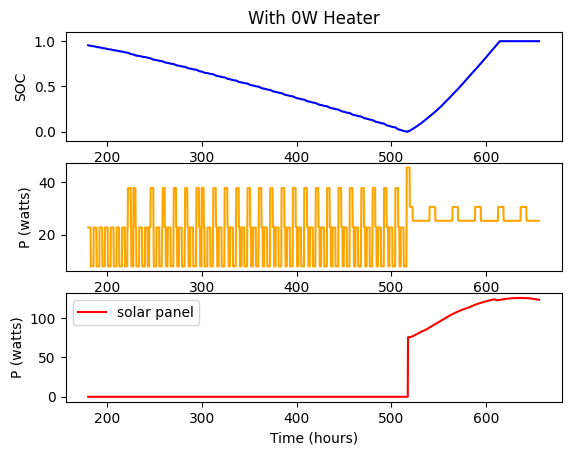

In [8]:
colors = ['b','g','k']
T = 0 ## we need this from Ryan
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
energy = 0
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
cond_heater = 0 ## 0 if no heater
for i in range(len(ryan_pvt['Nodes/Times']) - 1):
    deltaT =  3600*(ryan_pvt['Nodes/Times'].iloc[i+1] -ryan_pvt['Nodes/Times'].iloc[i])
    deltaT_list.append(deltaT)
    P =ryan_pvt['Summed_all'].iloc[i] + cond_heater ## added from heater per Ryan's suggestion
    
    if not solar_applied:
        sol_cont.append(0)
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        B.apply_age(deltaT)
        energy += deltaT*P
        #energy_l.append(energy)
        soc_values.append(B.SOC())
   
    if ryan_pvt['Nodes/Times'].iloc[i] >= 516.0 and not solar_applied:
       while solar_index <= (len(ryan_pvt['Nodes/Times'])-i): 
           ### discharging
           deltaT =  3600*(ryan_pvt['Nodes/Times'].iloc[solar_index+1] -ryan_pvt['Nodes/Times'].iloc[solar_index])
           P =ryan_pvt['Summed_all'].iloc[solar_index+i] + cond_heater ## added from heater per Ryan's suggestion
           B.apply_power(-P,deltaT) 
           power_values.append(P)
           
           
           ### charging
           P_add = sol_pvt['solar_pow'].iloc[solar_index]
           B.apply_power(P_add, deltaT)
           solar_index += 1
           energy += deltaT*(P_add-P)
           sol_cont.append(P_add)
           soc_values.append(B.SOC())
               #energy_l.append(energy)
           if len(soc_values) > len(ryan_pvt['Nodes/Times']) - 1:
                   break
           solar_applied = True

dict_val = {'Time':ryan_pvt['Nodes/Times'], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont}      
df = pd.DataFrame.from_dict(dict_val)
pd.DataFrame.to_csv(df,'t_soc_pow'+str(cond_heater)+'.csv')
                    
print(df)
plt.subplot(3, 1, 1)
plt.title('With '+str(cond_heater)+'W Heater')
plt.plot(ryan_pvt['Nodes/Times'], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
#plt.xlim(200,320)
plt.ylabel('SOC')
plt.subplot(3, 1, 2)
plt.plot(ryan_pvt['Nodes/Times'],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
 
plt.subplot(3, 1, 3)
plt.plot(ryan_pvt['Nodes/Times'], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.xlabel('Time (hours)')
plt.show() 


